In [1]:
import shutil
import pandas as pd
import numpy as np
import os
# torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 각 EER 및 Pooled EER 구하기

In [3]:
import pandas as pd
import os

def compute_eer(bonafide_scores, spoof_scores):
    from sklearn.metrics import roc_curve
    import numpy as np
    y_true = np.concatenate([np.ones(len(bonafide_scores)), np.zeros(len(spoof_scores))])
    y_scores = np.concatenate([bonafide_scores, spoof_scores])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    threshold = thresholds[eer_idx]
    return eer, threshold


# ======================================
# 경로 및 파일명 설정
# ======================================
eval_files = [
    "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/protocols/protocol_asv19_noise.txt",
    "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/protocols/protocol_deepen.txt",
    "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/protocols/protocol_df21_noise.txt",
    "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/protocols/protocol_itw.txt",
    "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/protocols/protocol_wildspoof.txt",
    "/home/woongjae/wildspoof/protocols/protocol_spoofceleb_5p_balance_augmented.txt"
]

# ✅ 경로 한 줄만 수정하면 됨
base_pred_path = "/home/woongjae/ADD_LAB/SSL_Fusion_ADD/results/spoofceleb_aug/crossattn"

# 각 eval 파일명에서 dataset 이름만 추출해서 동일한 이름의 예측 파일 경로 생성
pred_files = [
    os.path.join(base_pred_path, os.path.basename(e_file).replace("protocol", "eval"))
    for e_file in eval_files
]

dataset_names = ["ASV19", "Deepen", "DF21", "ITW", "WildSpoof", "SpoofCeleb_Aug"]

eval_dfs = []
results = []

print("=== Dataset-wise EER Results ===")
for name, e_file, p_file in zip(dataset_names, eval_files, pred_files):
    eval_df = pd.read_csv(e_file, sep=" ", header=None, names=["utt","subset", "label"])
    pred_df = pd.read_csv(p_file, sep=" ", header=None, names=["utt", "spoof", "bonafide"])
    merged = pd.merge(eval_df, pred_df, on="utt")

    spoof_scores = merged[merged['label'] == 'spoof']['bonafide']
    bonafide_scores = merged[merged['label'] == 'bonafide']['bonafide']

    eer, threshold = compute_eer(bonafide_scores, spoof_scores)
    print(f"{name:12s} - EER: {eer*100:.4f}% | Threshold: {threshold:.4f} | Samples: {len(merged)}")

    results.append({
        "Dataset": name,
        "EER(%)": round(eer * 100, 4),
        "Threshold": round(threshold, 4),
        "Samples": len(merged)
    })
    eval_dfs.append(merged)

# ======================================
# 전체 통합 결과 (Pooled)
# ======================================
pooled_df = pd.concat(eval_dfs, ignore_index=True)
spoof_scores = pooled_df[pooled_df['label'] == 'spoof']['bonafide']
bonafide_scores = pooled_df[pooled_df['label'] == 'bonafide']['bonafide']

eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("\n=== Pooled (All datasets combined) ===")
print("✅ Pooled EER: {:.4f}%, threshold: {:.4f}".format(eer * 100, threshold))
print("Total samples:", len(pooled_df))

# CSV로 저장
results.append({
    "Dataset": "Pooled",
    "EER(%)": round(eer * 100, 4),
    "Threshold": round(threshold, 4),
    "Samples": len(pooled_df)
})
results_df = pd.DataFrame(results)
results_df.to_csv("eer_results.csv", index=False)

print("\n📁 Saved: eer_results.csv")
print(results_df)


=== Dataset-wise EER Results ===
ASV19        - EER: 23.3789% | Threshold: 2.3412 | Samples: 77713
Deepen       - EER: 23.6111% | Threshold: 1.6009 | Samples: 7200
DF21         - EER: 16.8398% | Threshold: 0.1983 | Samples: 533928
ITW          - EER: 6.4571% | Threshold: 0.3306 | Samples: 31779
WildSpoof    - EER: 0.1042% | Threshold: 1.1301 | Samples: 127367
SpoofCeleb_Aug - EER: 2.6671% | Threshold: 0.7202 | Samples: 91130

=== Pooled (All datasets combined) ===
✅ Pooled EER: 9.4018%, threshold: 1.6470
Total samples: 869117

📁 Saved: eer_results.csv
          Dataset   EER(%)  Threshold  Samples
0           ASV19  23.3789     2.3412    77713
1          Deepen  23.6111     1.6009     7200
2            DF21  16.8398     0.1983   533928
3             ITW   6.4571     0.3306    31779
4       WildSpoof   0.1042     1.1301   127367
5  SpoofCeleb_Aug   2.6671     0.7202    91130
6          Pooled   9.4018     1.6470   869117


### Pooled EER 구하기

In [3]:
eval_files = [
    "/home/woongjae/wildspoof/protocols/protocol_asv19_noise.txt",
    "/home/woongjae/wildspoof/protocols/protocol_deepen.txt",
    "/home/woongjae/wildspoof/protocols/protocol_df21_noise.txt",
    "/home/woongjae/wildspoof/protocols/protocol_itw.txt",
    "/home/woongjae/wildspoof/protocols/protocol_wildspoof.txt"
]

pred_files = [
    "/home/woongjae/wildspoof/SFM-ADD/results/curriculum/eval_asv19_noise.txt",
    "/home/woongjae/wildspoof/SFM-ADD/results/curriculum/eval_deepen.txt",
    "/home/woongjae/wildspoof/SFM-ADD/results/curriculum/eval_df21_noise.txt",
    "/home/woongjae/wildspoof/SFM-ADD/results/curriculum/eval_itw.txt",
    "/home/woongjae/wildspoof/SFM-ADD/results/curriculum/eval_wildspoof.txt"
]

eval_dfs, pred_dfs = [], []

for e_file, p_file in zip(eval_files, pred_files):
    eval_df = pd.read_csv(e_file, sep=" ", header=None, names=["utt","subset", "label"])
    pred_df = pd.read_csv(p_file, sep=" ", header=None, names=["utt", "spoof", "bonafide"])
    merged = pd.merge(eval_df, pred_df, on="utt")
    eval_dfs.append(merged)

# 전체 데이터 통합
pooled_df = pd.concat(eval_dfs, ignore_index=True)
print(pooled_df['label'].unique())

spoof_scores = pooled_df[pooled_df['label'] == 'spoof']['bonafide']
bonafide_scores = pooled_df[pooled_df['label'] == 'bonafide']['bonafide']

eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("✅ Pooled EER: {:.4f}%, threshold: {:.4f}".format(eer * 100, threshold))
print("Total samples:", len(pooled_df))

['spoof' 'bonafide']
✅ Pooled EER: 29.8772%, threshold: 0.7478
Total samples: 1483881


### SSL-AAISST

In [19]:
eval_df = pd.read_csv("/home/woongjae/wildspoof/protocols/protocol_asv19_noise.txt",sep=" ", header=None)
eval_df.columns = ["utt","subset", 'label']
pred_df = pd.read_csv("/home/woongjae/wildspoof/SFM-ADD/results/baseline/eval_asv19_noise.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof", "bonafide"]

res_df = pd.merge(eval_df, pred_df, on='utt')

spoof_scores = res_df[res_df['label'] == 'spoof']['bonafide']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['bonafide']

eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))

EER: 25.2310%, threshold: 4.8491


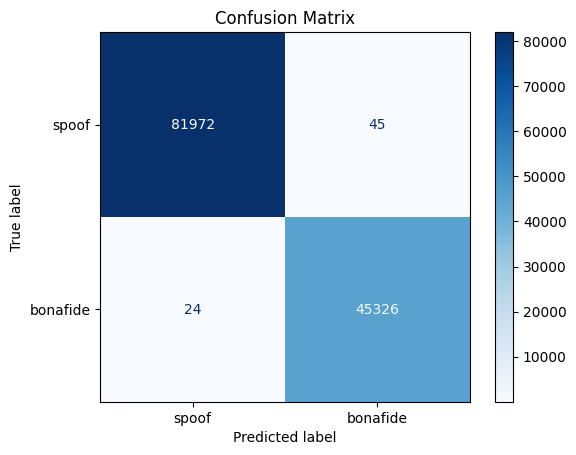

In [17]:
res_df['pred'] = res_df['bonafide'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print(res_df.head)

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Blues', values_format='g')
plt.title("Confusion Matrix")
plt.show()


### ConformerTCM

In [41]:
eval_df = pd.read_csv("/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/catastropy/g0.txt",sep=" ", header=None)
eval_df.columns = ["utt", 'subset','label']

pred_df = pd.read_csv("/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/results/FT-cata/conformertcm-g3-g0.txt", sep=" ", header=None)
pred_df.columns = ["utt", "bonafide"]
res_df = pd.merge(eval_df, pred_df, on='utt')
res_df.head()
spoof_scores = res_df[res_df['label'] == 'spoof']['bonafide']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['bonafide']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))

EER: 0.3252%, threshold: 2.1725


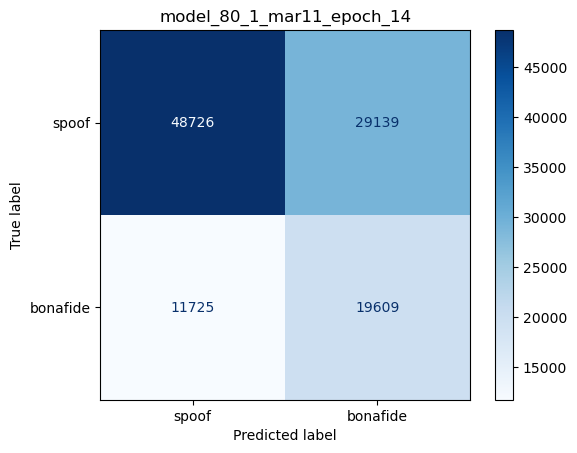

In [29]:
res_df['pred'] = res_df['bonafide'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print(res_df.head)

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Blues', values_format='g')
plt.title("model_80_1_mar11_epoch_14")
plt.show()
